## Explore and Calculate Metrics

Here we calculate metrics for final post-processed boxes and can look at how those metrics change with other steps in the post processing, if you want to.

In [1]:
# which metric file?
binary_dirs = 'binaries_model1/'

How do we want to quantify how well we are doing?

In [2]:
n_folds_cv = 5 # for calculating the spread in our metrics, we we'll do a CV
scoreminVec = [0.1, 0.5, 0.9] # list of minimum box "scores"
iouminVec = [0.1, 0.5, 0.6, 0.7, 0.75, 0.8, 0.9, 0.95] # list of IOU cut offs we want to explore

In [42]:
import pickle
import config
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
from metric_utils import calc_base_metrics_allboxes_cv, calc_prec_rec_f1_cv, print_metrics_table, \
  get_years_dataframe

In [4]:
# build up filename
pp = config.metric_results_dir
pp += binary_dirs.split('/')[0]
pp += '.pickle'
with open(pp, 'rb') as ff:
    icombo,imgs_name, truebox, pdfboxes, pdfrawboxes, captionText_figcap,\
                 bbox_figcap_pars,\
                 sboxes_cleaned, slabels_cleaned, sscores_cleaned,\
                 boxes_pdf, labels_pdf, scores_pdf,\
                 boxes_heur, labels_heur, scores_heur,\
                 boxes_heur2, labels_heur2, scores_heur2,\
                 boxes_par_found, labels_par_found, scores_par_found,\
                 boxes_sq1, labels_sq1, scores_sq1,\
                 boxes_sq2, labels_sq2, scores_sq2,\
                 boxes_sq3, labels_sq3, scores_sq3,\
                 boxes_sq4, labels_sq4, scores_sq4,\
                 boxes_sq5, labels_sq5, scores_sq5,\
                 truebox1,truebox2,truebox3,rotatedImage,LABELS = pickle.load(ff)

Final box analytics:

In [5]:
TPv, FPv, FNv, totalTruev = calc_base_metrics_allboxes_cv(LABELS,scoreminVec,iouminVec,
                                              truebox3,boxes_sq5,labels_sq5, 
                                              scores_sq5,n_folds_cv=n_folds_cv)

In [6]:
TPv.shape

(4, 3, 8, 5)

Shape is: (# labels, #scores, #ious, #CV folds)

Calculate precision, recall, F1 (ignore /0 warnings, taken care of):

In [7]:
precision, precision_std, recall, \
  recall_std, f1, f1_std = calc_prec_rec_f1_cv(TPv,FPv,FNv,
                                               LABELS,scoreminVec,
                                               iouminVec)

/Users/jillnaiman/figure_and_caption_extraction/metric_utils.py:223: RuntimeWarning: invalid value encountered in true_divide
  f = 2.0*(r*p)/(r+p)
/Users/jillnaiman/figure_and_caption_extraction/metric_utils.py:219: RuntimeWarning: invalid value encountered in true_divide
  p = TPv[:,i,j]/(TPv[:,i,j]+FPv[:,i,j])*100


Plot and check it out!

/Users/jillnaiman/anaconda3/envs/Paper1/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.


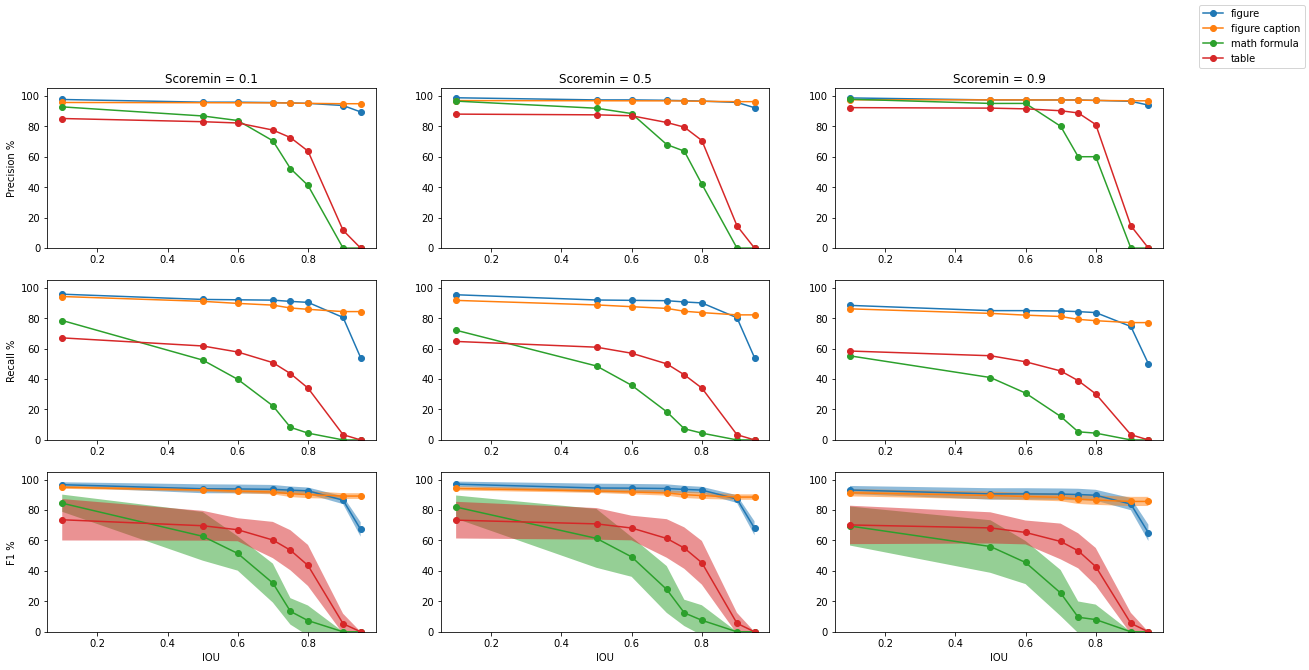

In [8]:
if len(scoreminVec) == 1:
    fig, ax = plt.subplots(3,len(scoreminVec),  figsize=(10,10))
    ax = np.array([ax,ax]).T
else:
    fig, ax = plt.subplots(3,len(scoreminVec),  figsize=(20,10))

ps = []
for i in range(len(scoreminVec)):
    for k in range(len(LABELS)): p1, = ax[0][i].plot(iouminVec,precision[k,i,:],'o-')
    ps.append(p1)
    ax[0][i].set_title('Scoremin = '+str(scoreminVec[i]))
    ax[0][0].set_ylabel('Precision %')
    ax[0][i].set_ylim(0,105)
    
    for k in range(len(LABELS)): ax[1][i].plot(iouminVec,recall[k,i,:], 'o-')
    ax[1][0].set_ylabel('Recall %')
    ax[1][i].set_ylim(0,105)
    
    for k in range(len(LABELS)): 
        ax[2][i].plot(iouminVec,f1[k,i,:], 'o-')
        # include stddev
        ax[2][i].fill_between(iouminVec, f1[k,i,:]-f1_std[k,i,:], f1[k,i,:]+f1_std[k,i,:], alpha=0.5)
    
    ax[2][0].set_ylabel('F1 %')
    ax[2][i].set_ylim(0,105)
        
    ax[-1][i].set_xlabel('IOU')

fig.legend(ps, labels=LABELS)
matplotlib.rcParams.update({'font.size': 12})
plt.show()

Choose a score cut-off.  For the most part, we've found 0.1 to be fine:

In [9]:
scoremin = 0.1 

What IOU cut-offs for each label? for reference:

In [10]:
LABELS

['figure', 'figure caption', 'math formula', 'table']

In [11]:
ioumin_per_label = [0.9, 0.95, 0.8, 0.8] # fig, fig+caption, math formula, table

In [12]:
#Shape is: (# labels, #scores, #ious, #CV folds)
TPs, FPs, FNs, totalTrues = calc_base_metrics_allboxes_cv(LABELS,[scoremin],ioumin_per_label,
                                              truebox3,boxes_sq5,labels_sq5, 
                                              scores_sq5,n_folds_cv=n_folds_cv)
totalTrue = totalTrues.sum(axis=1).astype('int') # collapse onto 1 axis
TP = np.diagonal(TPs[:,0,:,:].sum(axis=2)) # sum across all CV, then for the right IOU
FP = np.diagonal(FPs[:,0,:,:].sum(axis=2)) # sum across all CV, then for the right IOU
FN = np.diagonal(FNs[:,0,:,:].sum(axis=2)) # sum across all CV, then for the right IOU

In [13]:
precisions, precision_stds, recalls, \
  recall_stds, f1s, f1_stds = calc_prec_rec_f1_cv(TPs,FPs,FNs,
                                               LABELS,[scoremin],
                                               ioumin_per_label)
precision = np.diagonal(precisions[:,0,:]) 
precision_std = np.diagonal(precision_stds[:,0,:]) 
recall = np.diagonal(recalls[:,0,:]) 
recall_std = np.diagonal(recall_stds[:,0,:]) 
f1 = np.diagonal(f1s[:,0,:]) 
f1_std = np.diagonal(f1_stds[:,0,:]) 

/Users/jillnaiman/figure_and_caption_extraction/metric_utils.py:219: RuntimeWarning: invalid value encountered in true_divide
  p = TPv[:,i,j]/(TPv[:,i,j]+FPv[:,i,j])*100
/Users/jillnaiman/figure_and_caption_extraction/metric_utils.py:223: RuntimeWarning: invalid value encountered in true_divide
  f = 2.0*(r*p)/(r+p)


In [14]:
print_metrics_table(totalTrue,TP,FP,FN,
                        precision, precision_std, recall, recall_std,f1,f1_std,
                        LABELS, scoremin, n_folds_cv, ioumin_per_label)

SCORE =  0.1  N_CV =  5
Metric          figure          figure caption  math formula    table          
iou cut         0.9             0.95            0.8             0.8            
# of objs       503             468             114             112            
--------------------------------------------------------------------------------------------
TP              80.3%           84.4%           3.5%            32.1%          
FP              5.8%            4.9%            16.7%           17.9%          
FN              19.7%           15.6%           96.5%           67.9%          
--------------------------------------------------------------------------------------------
Precision       93.3+/-2.1%     94.6+/-1.2%     25.7+/-38.8%    59.3+/-21.3%   
Recall          80.3+/-5.2%     84.4+/-0.9%     3.2+/-4.0%      31.8+/-15.5%   
F1              86.2+/-2.7%     89.2+/-0.4%     5.6+/-6.9%      41.2+/-18.5%   


## Vs. Time
Also, let's plot metrics vs. year.

In [22]:
# pick a min score and a min IOU
scoremin = 0.1
ioumin = 0.8

In [26]:
years = []
for n in imgs_name:
    years.append(n.split('/')[-1][:4])
years_u = np.unique(years).astype('int')

In [27]:
#Shape is: (#years, # labels, #scores, #ious, #CV folds)

In [40]:
TPyear = np.zeros([len(years_u),len(LABELS)])
FPyear = np.zeros([len(years_u),len(LABELS)])
FNyear = np.zeros([len(years_u),len(LABELS)])
TTyear = np.zeros([len(years_u),len(LABELS)])

for t,b,l,s,y in zip(truebox3,boxes_sq5,labels_sq5,scores_sq5,years):
    TPv2, FPv2, FNv2, totalTruev2 = calc_base_metrics_allboxes_cv(LABELS,
                                                                  [scoremin],
                                                                  [ioumin],
                                                                  [t],[b],[l],[s],
                                                                  n_folds_cv=1)
    # then fill
    ind = np.where(years_u == int(y))[0]
    TPyear[ind,:] += TPv2.flatten()
    FPyear[ind,:] += FPv2.flatten()
    FNyear[ind,:] += FNv2.flatten()
    TTyear[ind,:] += totalTruev2.flatten()

In [49]:
df = pd.DataFrame({'years':years_u})
df['years'] = pd.to_datetime(df['years'],format="%Y")

# total each year
for il,l in enumerate(LABELS):
    df['total:'+l] = TTyear[:,il]
    
# true positive per year
for il,l in enumerate(LABELS):
    colname = 'TP:' + l
    df[colname] = TPyear[:,il]
    
# false positive each year
for il,l in enumerate(LABELS):
    colname = 'FP:' + l
    df[colname] = FPyear[:,il]
    
# false negative each year
for il,l in enumerate(LABELS):
    colname = 'FN:' + l
    df[colname] = FNyear[:,il]
    
# # precision per year - TP[i]/(TP[i]+FP[i])
# for il,l in enumerate(LABELS):
#     colname = 'prec:' + l
#     df[colname] = 100*TPyear[:,il]/(TPyear[:,il]+FPyear[:,il])
    
# # recall each year - TP[i]/(TP[i]+FN[i])
# for il,l in enumerate(LABELS):
#     colname = 'rec:' + l
#     df[colname] = 100*TPyear[:,il]/(TPyear[:,il]+FNyear[:,il])

# # f1 each year -- 2.0*(rec*prec)/(rec+prec)*100
# for il,l in enumerate(LABELS):
#     colname = 'F1:' + l
#     p = TPyear[:,il]/(TPyear[:,il]+FPyear[:,il]); r = TPyear[:,il]/(TPyear[:,il]+FNyear[:,il])
#     df[colname] = 100*(2.0*r*p)/(r+p)

In [44]:
df.head()

,years,total:figure,total:figure caption,total:math formula,total:table,TP:figure,TP:figure caption,TP:math formula,TP:table,FP:figure,...,prec:math formula,prec:table,rec:figure,rec:figure caption,rec:math formula,rec:table,F1:figure,F1:figure caption,F1:math formula,F1:table
0,1898-01-01,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
1,1907-01-01,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
2,1908-01-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1909-01-01,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,...,NaN,NaN,100.0,100.0,NaN,NaN,100.0,100.0,NaN,NaN
4,1913-01-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [45]:
sampleHist = '10Y' # 5 years

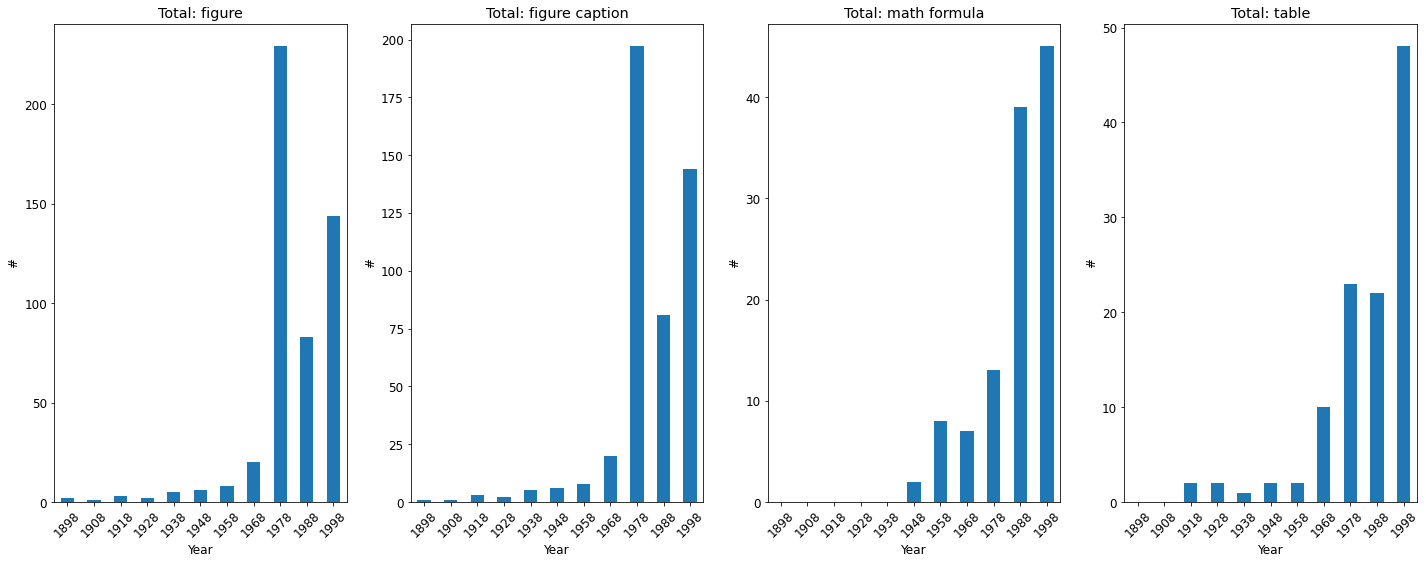

In [46]:
# loop and plot
fig, ax = plt.subplots(1,len(LABELS), figsize=(20,8))
matplotlib.rcParams.update({'font.size': 12})

for il,l in enumerate(LABELS):
    quant = pd.Series(index=df['years'],data=np.array(df['total:'+l])).resample(sampleHist).sum()
    
    quant.plot(kind='bar',ax=ax[il])
    ax[il].set_xticklabels([x.strftime("%Y") for x in quant.index], rotation=45)
    ax[il].set_title('Total: ' + l)
    ax[il].set_ylabel('#')
    ax[il].set_xlabel('Year')
#plt.show()

plt.tight_layout()
#plt.savefig(saveFigDir+'yolo_noOCR_articles_per_year.png')

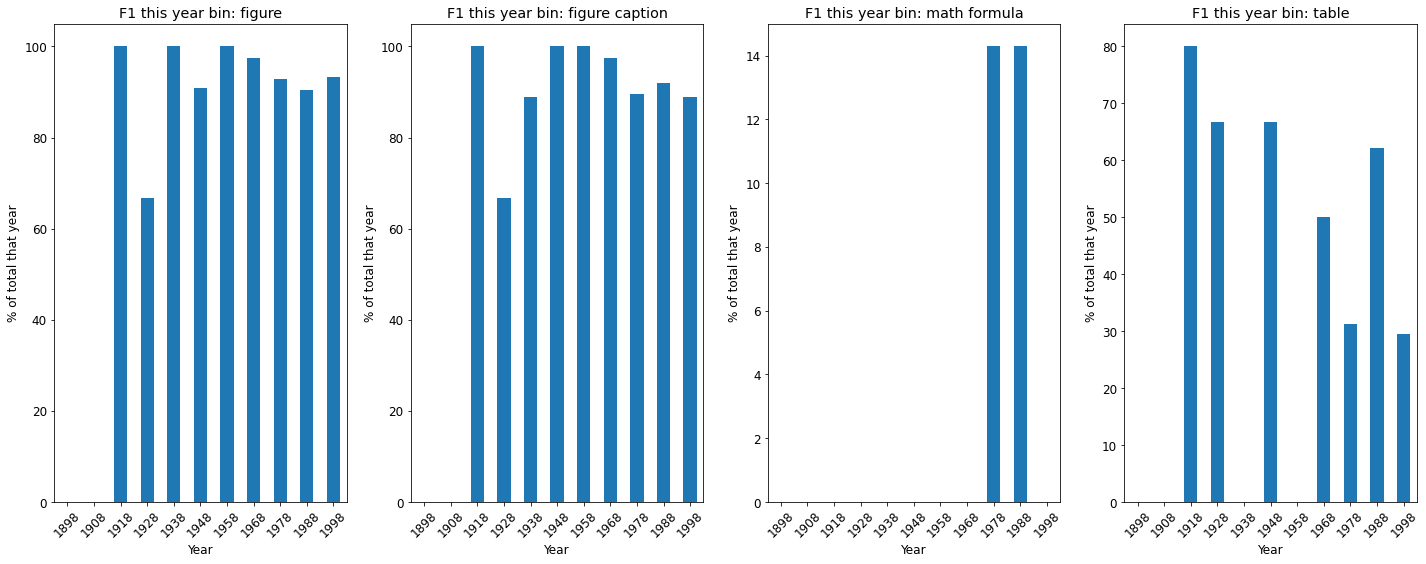

In [47]:
# loop and plot
qname = 'F1:'
bname = 'total:'
qlabel = 'F1'
fig, ax = plt.subplots(1,len(LABELS), figsize=(20,8))
matplotlib.rcParams.update({'font.size': 12})

for il,l in enumerate(LABELS):
    tp = pd.Series(index=df['years'],data=np.array(df['TP:'+l])).resample(sampleHist).sum()
    fp = pd.Series(index=df['years'],data=np.array(df['FP:'+l])).resample(sampleHist).sum()
    fn = pd.Series(index=df['years'],data=np.array(df['FN:'+l])).resample(sampleHist).sum()
    p = tp/(tp+fp); r = tp/(tp+fn)
    quant = 100*(2.0*r*p)/(r+p)
    quant.plot(kind='bar',ax=ax[il])
    ax[il].set_xticklabels([x.strftime("%Y") for x in quant.index], rotation=45)
    ax[il].set_title(qlabel+' this year bin: ' + l)
    ax[il].set_ylabel('% of total that year')
    ax[il].set_xlabel('Year')
    
plt.tight_layout()
plt.show()